In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train images shape: (42000, 32, 32)
Test images shape: (18000, 32, 32)
Train labels shape: (42000,)
Test labels shape: (18000,)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                 

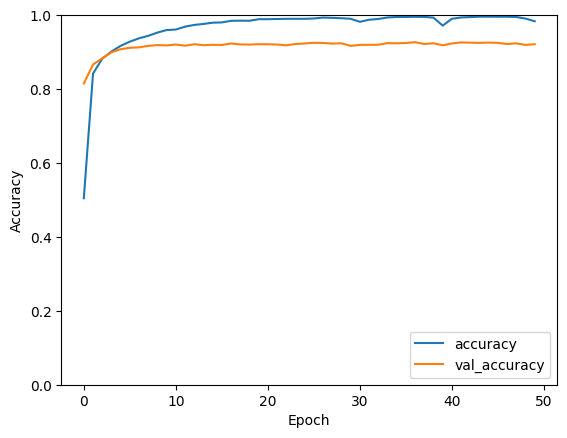

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 19 15:31:31 2024
"""
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

h5f = h5py.File('/content/drive/MyDrive/SVHN_single_grey1.h5', 'r')

x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

h5f.close() #close this file

# Preprocessing
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode labels (if needed for your model)
# This converts a vector of integer class labels to a binary matrix.

# Print the shapes of the preprocessed data
print("Train images shape:", x_train.shape)
print("Test images shape:", x_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

# Creating TripleNet_B Neural Network Model
def TripleNet_B(input_shape=(32, 32, 1), num_classes=10):

    # Shared convolutional layers
    input_img = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(32, (3, 3),
                          activation='relu',
                          padding='same')(input_img)
    conv1 = layers.MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = layers.MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = layers.MaxPooling2D((2, 2), padding='same')(conv3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = layers.MaxPooling2D((2, 2), padding='same')(conv4)

    # Layers
    anchor = layers.Flatten()(conv3)
    anchor = layers.Dense(256, activation='relu')(anchor)
    anchor = layers.Dropout(0.5)(anchor)
    anchor = layers.Dense(num_classes, activation='softmax', name='anchor')(anchor)

    positive = layers.Flatten()(conv3)
    positive = layers.Dense(256, activation='relu')(positive)
    positive = layers.Dropout(0.5)(positive)
    positive = layers.Dense(num_classes, activation='softmax', name='positive')(positive)

    negative = layers.Flatten()(conv3)
    negative = layers.Dense(256, activation='relu')(negative)
    negative = layers.Dropout(0.5)(negative)
    negative = layers.Dense(num_classes, activation='softmax', name='negative')(negative)

    # BiFPN branches
    branch1 = layers.Flatten()(conv4)
    branch1 = layers.Dense(256, activation='relu')(branch1)
    branch1 = layers.Dropout(0.5)(branch1)
    branch1 = layers.Dense(num_classes, activation='softmax', name='branch1')(branch1)

    # BiFPN branches
    branch2 = layers.Flatten()(conv4)
    branch2 = layers.Dense(256, activation='relu')(branch2)
    branch2 = layers.Dropout(0.5)(branch2)
    branch2 = layers.Dense(num_classes, activation='softmax', name='branch2')(branch2)

    # BiFPN branches
    branch3 = layers.Flatten()(conv4)
    branch3 = layers.Dense(256, activation='relu')(branch3)
    branch3 = layers.Dropout(0.5)(branch3)
    branch3 = layers.Dense(num_classes, activation='softmax', name='branch3')(branch3)

    # BiFPN branches
    branch4 = layers.Flatten()(conv4)
    branch4 = layers.Dense(256, activation='relu')(branch4)
    branch4 = layers.Dropout(0.5)(branch4)
    branch4 = layers.Dense(num_classes, activation='softmax', name='branch4')(branch4)

    # BiFPN branches
    branch5 = layers.Flatten()(conv4)
    branch5 = layers.Dense(256, activation='relu')(branch5)
    branch5 = layers.Dropout(0.5)(branch5)
    branch5 = layers.Dense(num_classes, activation='softmax', name='branch5')(branch5)

    # Fusion layer
    fusion = layers.Average()([anchor, positive, negative, branch1, branch2, branch3, branch4, branch5])

    model = models.Model(inputs=input_img, outputs=fusion)
    return model

# Train Test split
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build and compile the model
model = TripleNet_B()
bbox = (3, 3, 30, 30)

batch_size = 32;


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()





Mounted at /content/drive


563/563 [==============================] - 2s 3ms/step


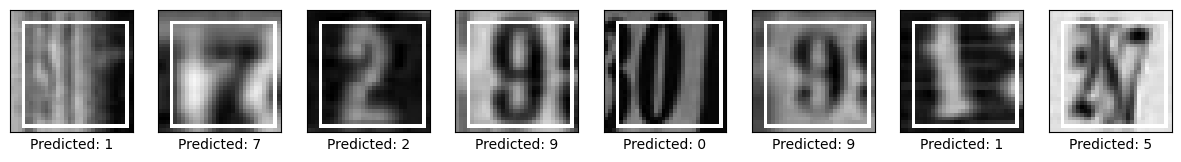

In [ ]:
# Make predictions
import cv2
predictions = model.predict(x_test)


# Plot a few test images with their predicted labels
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    temp = cv2.rectangle(x_test[i].copy(), (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
    plt.imshow(temp, cmap=plt.cm.binary)
    plt.xlabel(f'Predicted: {tf.argmax(predictions[i]).numpy()}')
plt.show()




1/1 [==============================] - 0s 17ms/step


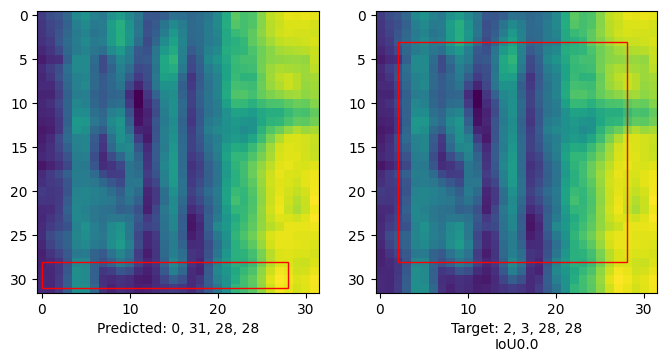

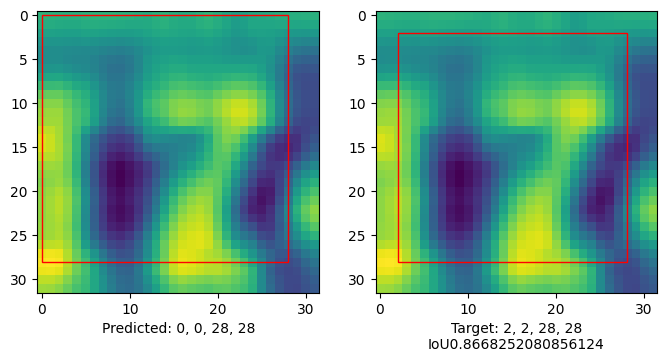

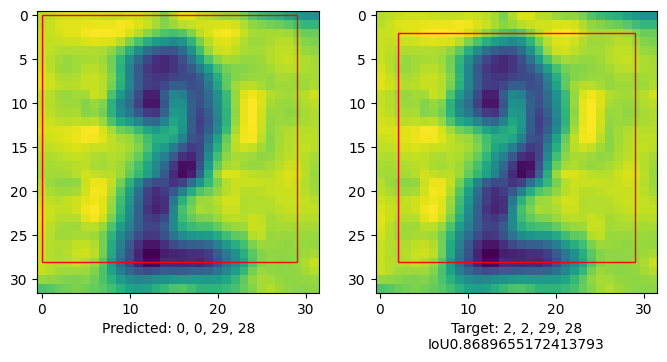

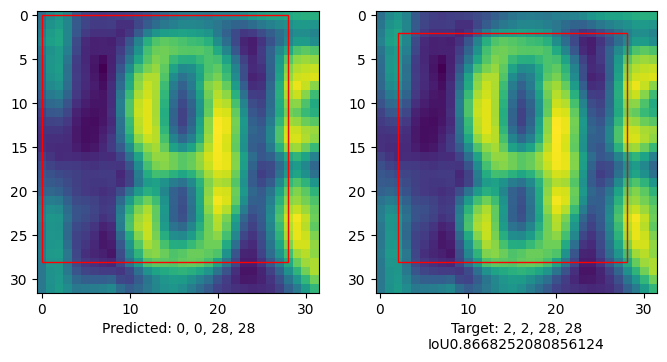

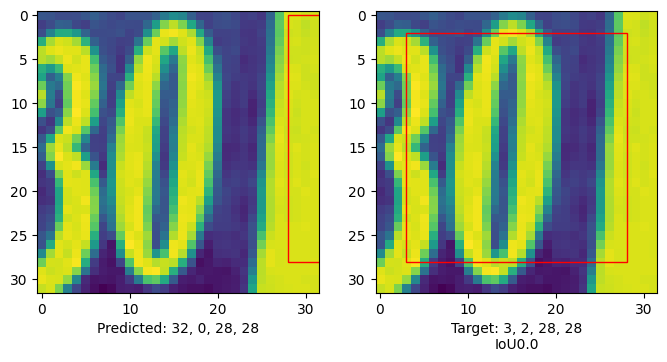

In [ ]:
import matplotlib.patches as patches
import numpy as np
image_size = 32

def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )
L = 28
i, mean_iou = 0, 0

for input_image in x_test[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    im = input_image

    # Display the image
    ax1.imshow(im)
    ax2.imshow(im)

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] + L), int(preds[3] + L )

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] + 2), int(y_test[i][1] + 2)

    bottom_right_x, bottom_right_y = int(y_test[i][2] + L), int(y_test[i][3] + L)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

plt.show()